# Knights Feature Selection
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* October 27, 2021

## Hypothesis
Write about the hunch you have and why you're running this experiment.

## Experiment
Document the experiment including selecting data, data transformations, feature engineering and modelling

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
from pycaret.classification import *
from ngboost import NGBClassifier

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password········


In [3]:
lkupclientid = 46 # Knights

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMILB].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lkupClientId              544 non-null    int64  
 1   dimCustomerMasterId       544 non-null    int64  
 2   customerNumber            544 non-null    object 
 3   year                      544 non-null    object 
 4   productGrouping           544 non-null    object 
 5   totalSpent                544 non-null    float64
 6   recentDate                544 non-null    object 
 7   attendancePercent         544 non-null    float64
 8   renewedBeforeDays         544 non-null    int64  
 9   isBuyer                   544 non-null    object 
 10  source_tenure             544 non-null    int64  
 11  tenure                    544 non-null    int64  
 12  distToVenue               544 non-null    float64
 13  totalGames                544 non-null    int64  
 14  recency   

### Let's drop the features that have lots of null values:

In [4]:
df.drop([ 
    'lengthOfResidenceInYrs',
    'annualHHIncome',
    'education',
    'urbanicity',
    'isnextyear_buyer',
    'isnextyear_samepkg_buyer',
    'pkgupgrade_status',
    'auto_renewal'],
    axis=1, 
    inplace=True
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 47 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   lkupClientId          544 non-null    int64  
 1   dimCustomerMasterId   544 non-null    int64  
 2   customerNumber        544 non-null    object 
 3   year                  544 non-null    object 
 4   productGrouping       544 non-null    object 
 5   totalSpent            544 non-null    float64
 6   recentDate            544 non-null    object 
 7   attendancePercent     544 non-null    float64
 8   renewedBeforeDays     544 non-null    int64  
 9   isBuyer               544 non-null    object 
 10  source_tenure         544 non-null    int64  
 11  tenure                544 non-null    int64  
 12  distToVenue           544 non-null    float64
 13  totalGames            544 non-null    int64  
 14  recency               544 non-null    int64  
 15  missed_games_1        5

### In order to compare two sets of features, we need to create some datasets for training and evalution:

In [5]:
df_train_A = df.sample(frac=0.9, random_state=786)
df_train_B = df.sample(frac=0.9, random_state=786)

df_eval_A = df.drop(df_train_A.index)
df_eval_B = df.drop(df_train_B.index)

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

Data for Modeling (A Class): (490, 47)
Unseen Data For Predictions: (54, 47)
Data for Modeling (A Class): (490, 47)
Unseen Data For Predictions: (54, 47)


### Let's also drop the features that only have a single value, as they won't add much differentiation to our model:

In [6]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)
        
df.shape

(544, 17)

### We should also drop features that have a low correlation with the target label as they won't be useful for prediction, we'll only keep features that have a correlation above a set threshold:

In [7]:
cor = df.corr()

threshold = 0.05

#Correlation with output variable
cor_target = abs(cor["isNextYear_Buyer"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target > threshold]

feats = []
for name, val in relevant_features.items():
    feats.append(name)

df_correlated = df[feats]

df_correlated.shape

df_correlated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dimCustomerMasterId  544 non-null    int64  
 1   attendancePercent    544 non-null    float64
 2   source_tenure        544 non-null    int64  
 3   tenure               544 non-null    int64  
 4   totalGames           544 non-null    int64  
 5   recency              544 non-null    int64  
 6   missed_games_1       544 non-null    int64  
 7   missed_games_2       544 non-null    int64  
 8   isNextYear_Buyer     544 non-null    int64  
dtypes: float64(1), int64(8)
memory usage: 38.4 KB


### Now that we have the right features we can look at the correlations between them, if features are highly correlated with each other it might negatively impact the model:

In [8]:
corr = df_correlated.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,dimCustomerMasterId,attendancePercent,source_tenure,tenure,totalGames,recency,missed_games_1,missed_games_2,isNextYear_Buyer
dimCustomerMasterId,1.00,0.17,0.16,0.16,0.21,-0.13,0.09,0.09,0.09
attendancePercent,0.17,1.00,-0.08,-0.08,0.52,-0.45,0.42,0.09,0.13
source_tenure,0.16,-0.08,1.00,1.00,0.05,0.11,-0.04,0.11,-0.28
tenure,0.16,-0.08,1.00,1.00,0.05,0.11,-0.04,0.11,-0.28
totalGames,0.21,0.52,0.05,0.05,1.00,-0.38,0.59,0.25,0.32
recency,-0.13,-0.45,0.11,0.11,-0.38,1.00,-0.25,-0.13,-0.12
missed_games_1,0.09,0.42,-0.04,-0.04,0.59,-0.25,1.00,0.26,0.27
missed_games_2,0.09,0.09,0.11,0.11,0.25,-0.13,0.26,1.00,0.08
isNextYear_Buyer,0.09,0.13,-0.28,-0.28,0.32,-0.12,0.27,0.08,1.00


### In order to compare two sets of features, we need to create some datasets for training and evalution:


In [9]:
# select % of the data for training
df_train = df_correlated.sample(frac=0.8, random_state=786).reset_index(drop=True)

# create the eval datasets for A and B
df_eval = df_correlated.drop(df_train.index).reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (435, 9)
Unseen Data For Predictions: (109, 9)



## Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [11]:
from sklearn.impute import SimpleImputer
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.80,
    data_split_shuffle=True,
    silent=True,
    numeric_features=[
        "attendancePercent",
        "source_tenure",
        "tenure",
        "totalGames",
        "missed_games_1",
        "missed_games_2"
    ]
)

,Description,Value
0,session_id,1165
1,Target,isNextYear_Buyer
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(435, 9)"
5,Missing Values,False
6,Numeric Features,8
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


(252    1
 383    1
 344    1
 64     1
 375    0
       ..
 146    1
 188    1
 212    0
 54     1
 29     1
 Name: isNextYear_Buyer, Length: 348, dtype: int64,
      dimCustomerMasterId  attendancePercent  source_tenure  totalGames  \
 252          351151616.0           0.064516          547.0         3.0   
 383          356127104.0           0.634409          547.0        27.0   
 344          355057248.0           0.741935          815.0        24.0   
 64           323693728.0           0.709677          234.0        22.0   
 375          356120096.0           0.344828           59.0        11.0   
 ..                   ...                ...            ...         ...   
 146          356122464.0           0.677419          265.0        23.0   
 188          323693632.0           0.935484          178.0        29.0   
 212          352049344.0           0.193548         1000.0         6.0   
 54           356122944.0           0.833333          448.0        13.0   
 29          

In [12]:
# adding an extra classifier ngboost
ngc = NGBClassifier()
ngboost = create_model(ngc)

model_matrix = compare_models(
    fold=10,
    include=["ada","dt","gbc","et","knn","lightgbm","lr","rf",ngboost,"xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Ada Boost Classifier,0.7471,0.8026,0.7308,0.7113,0.7172,0.4893,0.4933,0.0270
8,NGBClassifier,0.7414,0.8405,0.7617,0.6927,0.7227,0.4820,0.4870,0.2850
2,Gradient Boosting Classifier,0.7301,0.8012,0.7183,0.6864,0.6983,0.4550,0.4593,0.0260
7,Random Forest Classifier,0.7128,0.8176,0.6788,0.6794,0.6725,0.4179,0.4242,0.1860
9,Extreme Gradient Boosting,0.7072,0.7877,0.6404,0.6842,0.6516,0.4023,0.4107,0.1830
5,Light Gradient Boosting Machine,0.6984,0.7968,0.6596,0.6631,0.6548,0.3882,0.3943,0.0160
3,Extra Trees Classifier,0.6982,0.7851,0.6454,0.6676,0.6503,0.3858,0.3913,0.1760
1,Decision Tree Classifier,0.6924,0.6871,0.6392,0.6675,0.6472,0.3754,0.3812,0.0040
4,K Neighbors Classifier,0.6493,0.6428,0.6350,0.6017,0.6153,0.2947,0.2975,0.0460
6,Logistic Regression,0.5546,0.4331,0.0000,0.0000,0.0000,0.0000,0.0000,0.0050


### The top model is performing well, so let's compare it against our unseen eval dataset:


In [13]:
best_model = create_model(model_matrix)

unseen_predictions = predict_model(best_model, data=df_eval)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7429,0.7270,0.7500,0.7059,0.7273,0.4845,0.4852
1,0.7429,0.8289,0.6875,0.7333,0.7097,0.4793,0.4801
2,0.7143,0.7829,0.7500,0.6667,0.7059,0.4300,0.4328
3,0.6857,0.6974,0.5000,0.7273,0.5926,0.3508,0.3671
4,0.7429,0.8059,0.6875,0.7333,0.7097,0.4793,0.4801
5,0.7429,0.8133,0.7333,0.6875,0.7097,0.4793,0.4801
6,0.8000,0.8467,0.8667,0.7222,0.7879,0.6016,0.6106
7,0.8286,0.9117,0.8667,0.7647,0.8125,0.6557,0.6601
8,0.7647,0.8035,0.8000,0.7059,0.7500,0.5294,0.5331
9,0.7059,0.8088,0.6667,0.6667,0.6667,0.4035,0.4035


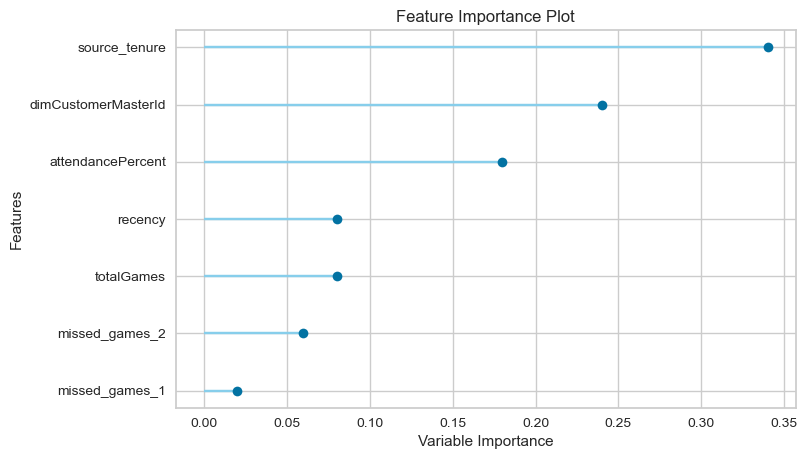

In [14]:
plot_model(best_model, plot='feature')

In [21]:
plot_model(best_model, plot='confusion_matrix')

IntProgress(value=0, description='Processing: ', max=5)

Finished loading model, total used 100 iterations


AttributeError: 'Pipeline' object has no attribute 'fig'

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?